In [1]:
#@title MIT License
#
# Copyright (c) 2019 Andreas Eberlein
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Train a deep neural network for semantic segmentation based on Virtual KITTI dataset

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
import tensorflow.keras.utils as utils
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers


import cv2
import pickle
import h5py

In [3]:
import data_helper

In [4]:
processed_training_data_file_name = "../Data_compressed/Preprocessed/ProcessedTrainingData.hdf5"

data_file = h5py.File(processed_training_data_file_name, 'r')

one_hot_encoded_labels = data_file['one_hot_encoded_labels']
train_images = data_file['training_images']

In [5]:
# Briefly check whether reimport of data worked out
print(one_hot_encoded_labels.shape)
print(train_images.shape)

(447, 125, 414, 14)
(447, 125, 414, 3)


In [6]:
dict_file_name = '../Data_compressed/Preprocessed/Dictionaries.dat'
dict_file = open(dict_file_name, 'rb')
value_category_id_mappings = pickle.load(dict_file)
dict_file.close()
values_categories_dict, categories_ids_dict, ids_categories_dict, \
            ids_values_dict, values_ids_dict = value_category_id_mappings
print(categories_ids_dict)
print(ids_values_dict)

{'GuardRail': 0, 'Terrain': 1, 'Car': 2, 'Pole': 3, 'Vegetation': 4, 'Truck': 5, 'TrafficSign': 6, 'Sky': 7, 'TrafficLight': 8, 'Misc': 9, 'Van': 10, 'Road': 11, 'Building': 12, 'Tree': 13}
{0: (255, 100, 255), 1: (210, 0, 200), 2: (200, 200, 200), 3: (255, 130, 0), 4: (90, 240, 0), 5: (160, 60, 60), 6: (255, 255, 0), 7: (90, 200, 255), 8: (200, 200, 0), 9: (80, 80, 80), 10: (230, 208, 202), 11: (100, 60, 100), 12: (140, 140, 140), 13: (0, 199, 0)}


In [7]:
# Now we reconstruct a few label images from one-hot encoding to colour coding for testing purposes
decoded_labels = data_helper.oneHotDecodeImages(one_hot_encoded_labels[0:4], ids_values_dict)

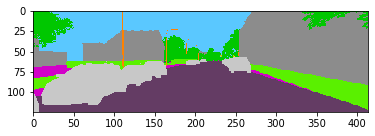

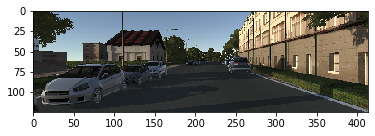

In [8]:
data_helper.plot_as_rgb_image(decoded_labels[0])
plt.show()
data_helper.plot_as_rgb_image(train_images[0])
plt.show()

## Setting model and training parameters

In [9]:
batch_size = 8
epochs = 150
img_shape = train_images[0].shape
img_shape

(125, 414, 3)

## Define model
The stated results for quality metrics are for `batch_size = 8`, `epochs = 50`, `160` training images and a fixed learning rate of `0.0001`.

W0718 06:20:42.358355 140610242672448 deprecation.py:506] From /home/andreas/Programmieren_MachineLearning/anaconda3/envs/VirtualKITTI/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


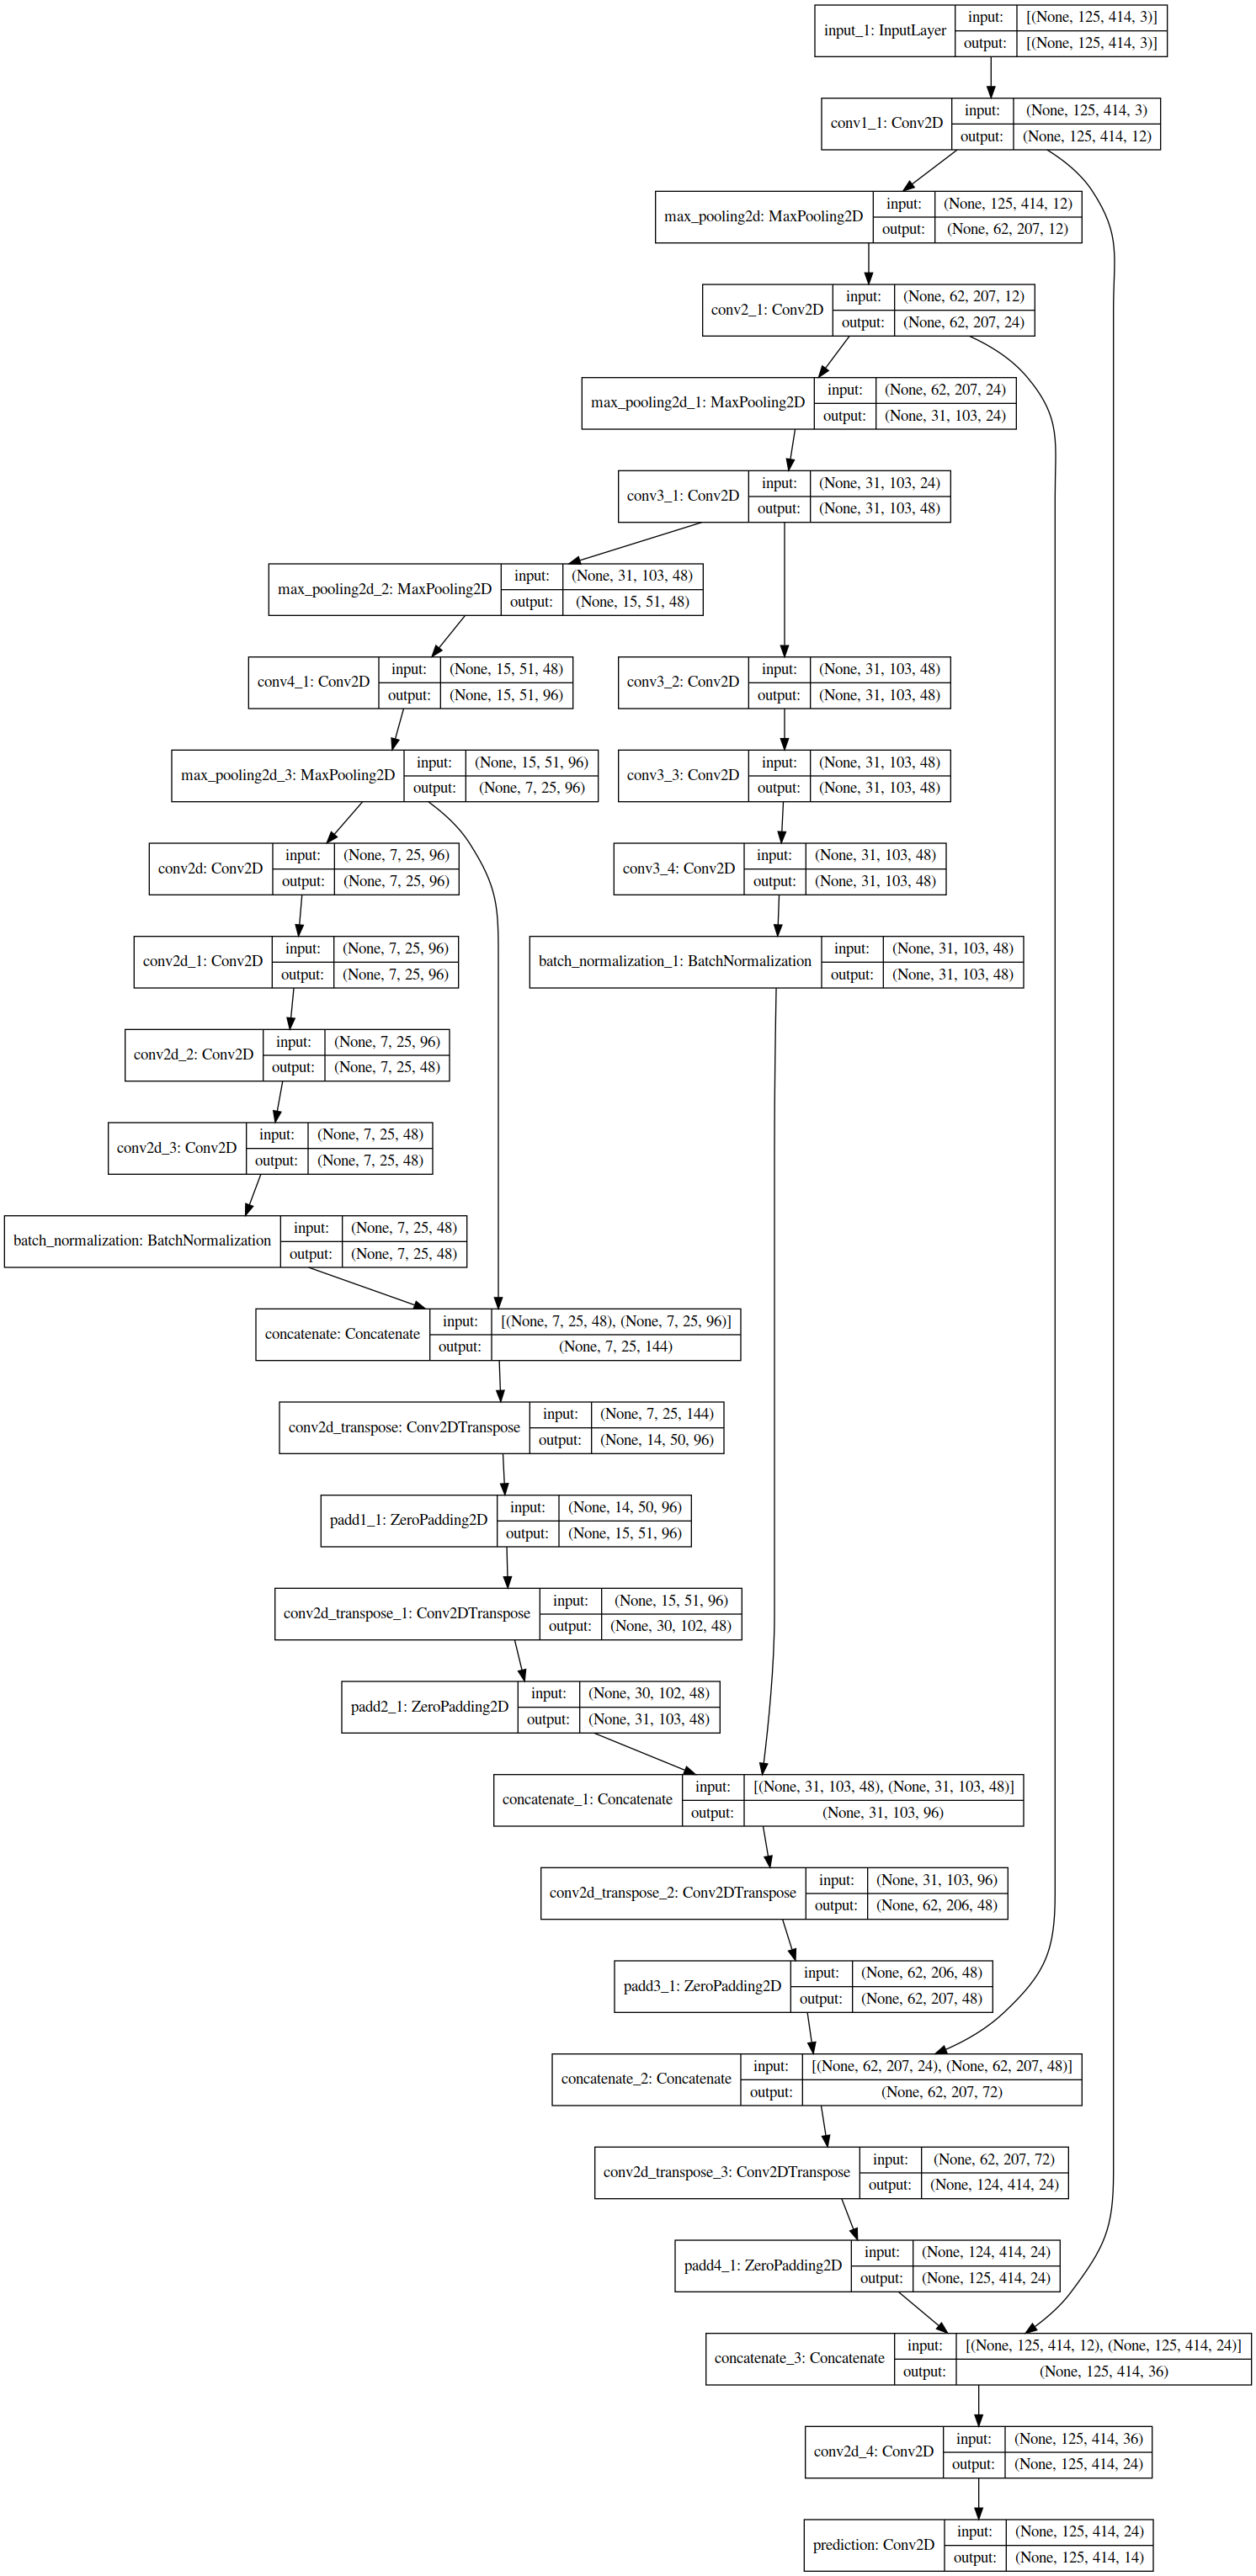

In [10]:
def multiBranchWithSkipLayers():
    # Architecture inspired by U-net and Fast-SCNN (1902.04502)
    inputs = layers.Input(shape=img_shape)
    # Encoder part
    conv1_1 = layers.Conv2D(12, 3, padding='same', activation='relu', name='conv1_1')(inputs)
    pool1_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_1)
    conv2_1 = layers.Conv2D(24, 3, padding='same', activation='relu', name='conv2_1')(pool1_1)
    pool2_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_1')(pool2_1)
    pool3_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = layers.Conv2D(96, 3, padding='same', activation='relu', name='conv4_1')(pool3_1)
    pool4_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_1)
    
    # Bottleneck layers for deep part
    conv5_1 = layers.Conv2D(96, 1, padding='same', activation='relu')(pool4_1)
    conv6_1 = layers.Conv2D(96, 3, padding='same', activation='relu')(conv5_1)
    conv7_1 = layers.Conv2D(48, 3, padding='same', activation='relu')(conv6_1)
    conv8_1 = layers.Conv2D(48, 1, padding='same', activation='relu')(conv7_1)
    bottleneck_output = layers.BatchNormalization()(conv8_1)
    
    # Convolutional layers for "intermediate part"
    conv3_2 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_2')(conv3_1)
    conv3_3 = layers.Conv2D(48, 1, padding='same', activation='relu', name='conv3_3')(conv3_2)
    conv3_4 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_4')(conv3_3)
    conv3_4_norm = layers.BatchNormalization()(conv3_4)
    
    # Decoder part
    concat0_1 = layers.Concatenate()([bottleneck_output, pool4_1])
    deconv1_1 = layers.Conv2DTranspose(96, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat0_1)
    padd1_1 = layers.ZeroPadding2D(padding=((0,1), (0,1)), name='padd1_1')(deconv1_1)
    deconv2_1 = layers.Conv2DTranspose(48, 3, strides=(2,2), padding='same',
                                       activation='relu')(padd1_1)
    padd2_1 = layers.ZeroPadding2D(padding=((0,1), (0,1)), name='padd2_1')(deconv2_1)
    concat1_1 = layers.Concatenate()([conv3_4_norm, padd2_1])
    deconv3_1 = layers.Conv2DTranspose(48, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat1_1)
    padd3_1 = layers.ZeroPadding2D(padding=((0,0), (0,1)), name='padd3_1')(deconv3_1)
    concat2_1 = layers.Concatenate()([conv2_1, padd3_1])
    deconv4_1 = layers.Conv2DTranspose(24, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat2_1)
    padd4_1 = layers.ZeroPadding2D(padding=((0,1), (0,0)), name='padd4_1')(deconv4_1)
    concat3_1 = layers.Concatenate()([conv1_1, padd4_1])
    deconv5_1 = layers.Conv2D(24, 3, padding='same', activation='relu')(concat3_1)
    
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax, name='prediction')(deconv5_1)
    
    # Ideas for optimization:
    # - Introduce DepthwiseConv2d instead of Conv2d on encoder path
    # - Use upsampling for very heavy Conv2DTranspose layers
    # - Conveniently cut images so that zero padding is unnecessary
    # - Introduce batch normalization on every branch that is merged via concatenation
    # - Use more images during training!
    
    return models.Model(inputs=inputs, outputs=predictions)

model = multiBranchWithSkipLayers()
utils.plot_model(model, to_file='model.png', show_shapes=True)

In [11]:
optimizer = optimizers.RMSprop()

model.compile(optimizer=optimizer,
              # loss=losses.mean_absolute_error,
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', metrics.MeanIoU(num_classes=one_hot_encoded_labels.shape[3])]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 414, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 125, 414, 12) 336         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 207, 12)  0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 62, 207, 24)  2616        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [12]:
def learning_rate_schedule(epoch):
    return 0.001 / 3**(epoch // 50)

lr_schedule = callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)

history = model.fit(train_images[0:], one_hot_encoded_labels[0:], epochs=epochs,
                   validation_split=0.15, verbose=1, initial_epoch=0, callbacks=[lr_schedule])

Train on 379 samples, validate on 68 samples


W0718 06:21:39.187904 140610242672448 deprecation.py:323] From /home/andreas/Programmieren_MachineLearning/anaconda3/envs/VirtualKITTI/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/150
379/379 [==============================] - 724s 2s/sample - loss: 4.5730 - acc: 0.2140 - mean_io_u: 0.4642 - val_loss: 2.5776 - val_acc: 0.2167 - val_mean_io_u: 0.4643

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/150
379/379 [==============================] - 368s 970ms/sample - loss: 2.0835 - acc: 0.4118 - mean_io_u: 0.4643 - val_loss: 1.9114 - val_acc: 0.3610 - val_mean_io_u: 0.4643

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/150
379/379 [==============================] - 264s 697ms/sample - loss: 1.5462 - acc: 0.5704 - mean_io_u: 0.4643 - val_loss: 1.3876 - val_acc: 0.6066 - val_mean_io_u: 0.4643

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/150
379/379 [==============================] - 86s 226ms/sample - loss: 1.3248 - acc: 0.6134 - mean_io_u: 0.4643 - val_loss: 1.2481 - val_acc: 0.6476 - val_mean_io_u: 0.4


Epoch 00065: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 65/150
379/379 [==============================] - 86s 226ms/sample - loss: 0.1243 - acc: 0.9606 - mean_io_u: 0.4744 - val_loss: 0.1560 - val_acc: 0.9526 - val_mean_io_u: 0.4732

Epoch 00066: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 66/150
379/379 [==============================] - 86s 226ms/sample - loss: 0.1244 - acc: 0.9605 - mean_io_u: 0.4745 - val_loss: 0.1551 - val_acc: 0.9517 - val_mean_io_u: 0.4718

Epoch 00067: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 67/150
379/379 [==============================] - 86s 226ms/sample - loss: 0.1202 - acc: 0.9618 - mean_io_u: 0.4744 - val_loss: 0.1533 - val_acc: 0.9528 - val_mean_io_u: 0.4713

Epoch 00068: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 68/150
379/379 [==============================] - 86s 226ms/sample - loss: 0.1183 - acc: 0.9623 - mean_io

379/379 [==============================] - 86s 228ms/sample - loss: 0.0675 - acc: 0.9777 - mean_io_u: 0.4929 - val_loss: 0.1161 - val_acc: 0.9661 - val_mean_io_u: 0.4889

Epoch 00126: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 126/150
379/379 [==============================] - 87s 230ms/sample - loss: 0.0671 - acc: 0.9779 - mean_io_u: 0.4925 - val_loss: 0.1178 - val_acc: 0.9653 - val_mean_io_u: 0.4882

Epoch 00127: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 127/150
379/379 [==============================] - 86s 228ms/sample - loss: 0.0675 - acc: 0.9777 - mean_io_u: 0.4925 - val_loss: 0.1171 - val_acc: 0.9656 - val_mean_io_u: 0.4943

Epoch 00128: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 128/150
379/379 [==============================] - 90s 236ms/sample - loss: 0.0662 - acc: 0.9781 - mean_io_u: 0.4934 - val_loss: 0.1154 - val_acc: 0.9661 - val_mean_io_u: 0.4898

Epoch 00129: Learni

In [13]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist

,loss,acc,mean_io_u,val_loss,val_acc,val_mean_io_u,lr
0,4.572985,0.214023,0.464235,2.577634,0.216697,0.464288,0.001000
1,2.083468,0.411812,0.464294,1.911444,0.361047,0.464286,0.001000
2,1.546249,0.570367,0.464287,1.387613,0.606620,0.464285,0.001000
3,1.324835,0.613433,0.464288,1.248141,0.647591,0.464494,0.001000
4,1.195941,0.642391,0.464987,1.089796,0.672216,0.464285,0.001000
5,1.017323,0.687180,0.464289,1.012425,0.695198,0.464361,0.001000
6,0.914597,0.721903,0.464348,1.256767,0.583002,0.464286,0.001000
7,0.858800,0.737205,0.464509,0.829193,0.746669,0.464347,0.001000
8,0.728326,0.774940,0.464321,0.803402,0.751757,0.464379,0.001000
9,0.689219,0.785809,0.464461,0.823080,0.756625,0.464289,0.001000


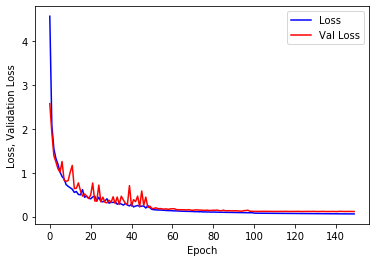

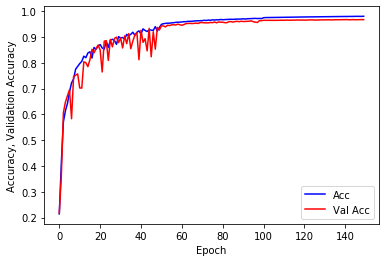

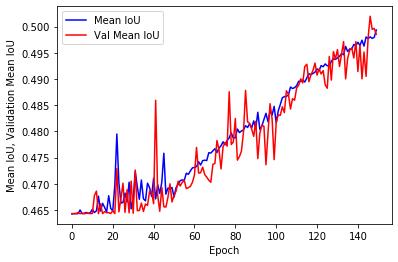

In [16]:
start = 0
end = epochs
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss, Validation Loss')
plt.plot(hist['loss'][start:end], 'b-', label='Loss')
plt.plot(hist['val_loss'][start:end], 'r-', label='Val Loss')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy, Validation Accuracy')
plt.plot(hist['acc'][start:end], 'b-', label='Acc')
plt.plot(hist['val_acc'][start:end], 'r-', label='Val Acc')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean IoU, Validation Mean IoU')
plt.plot(hist['mean_io_u'][start:end], 'b-', label='Mean IoU')
plt.plot(hist['val_mean_io_u'][start:end], 'r-', label='Val Mean IoU')
plt.legend()

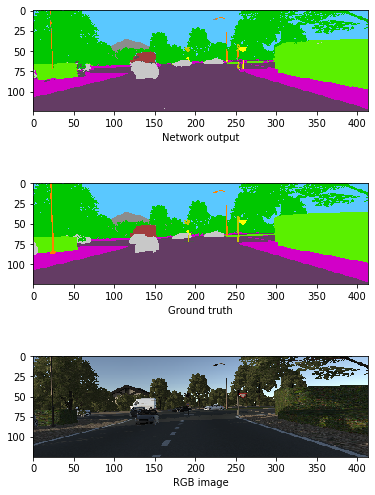

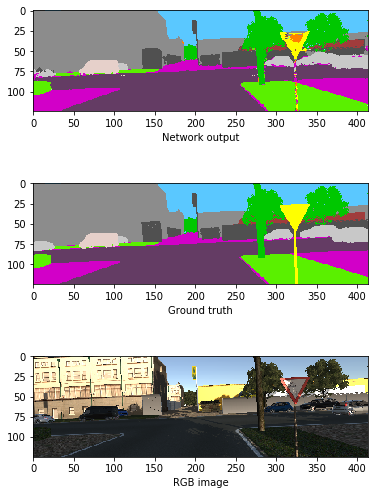

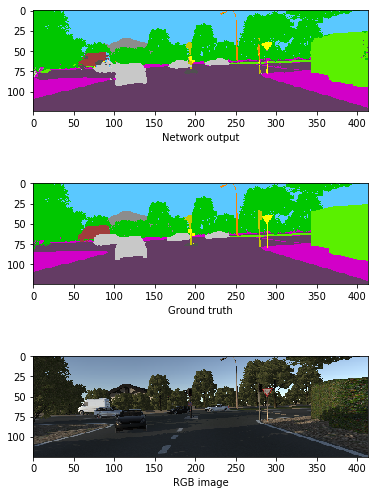

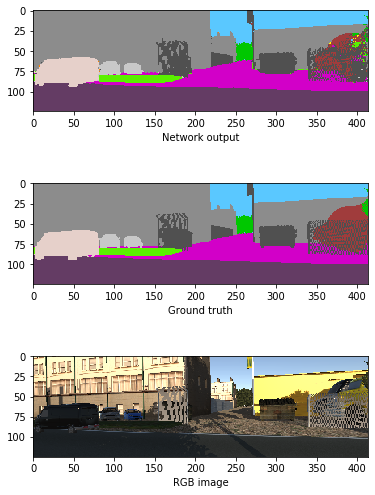

In [17]:
# Plot a few images for visualizing the results:
test_prediction = model.predict(train_images[-4:])
test_prediction_decoded = data_helper.oneHotDecodeImages(test_prediction, ids_values_dict)
ground_truth_decoded = data_helper.oneHotDecodeImages(one_hot_encoded_labels[-4:], ids_values_dict)

for idx in range(-4, 0, 1):
    fig = plt.figure(figsize=(6, 9))
    fig.add_subplot(3, 1, 1)
    data_helper.plot_as_rgb_image(test_prediction_decoded[idx])
    plt.xlabel('Network output')
    fig.add_subplot(3, 1, 2)
    data_helper.plot_as_rgb_image(ground_truth_decoded[idx])
    plt.xlabel('Ground truth')
    fig.add_subplot(3, 1, 3)
    data_helper.plot_as_rgb_image(train_images[idx])
    plt.xlabel('RGB image')
    plt.savefig('result_example_' + str(idx+5) + '.png')
    plt.show()
    print()

In [18]:
data_file.close()

## To do:

- Optimize network architecture?